In [ ]:
import sys
sys.path.append("./..")

import tsdb
import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from src.data.datatool import DataProcessor

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)


## Data voorbereiden

In [ ]:
dataset = 'physionet_2012'
data = tsdb.load(dataset)
config = {}

print(data.keys())

df_a  = pd.DataFrame(data['set-a'])
df_outcomes_a  = pd.DataFrame(data['outcomes-a']).reset_index()
df_static_features  = pd.DataFrame(data['static_features'])

id = "RecordID"
time = "Time"
target = "In-hospital_death"
global_features = list(df_static_features.iloc[:,0])


processor = DataProcessor(
    df=df_a,
    df_label=df_outcomes_a,  
    id_col=id, 
    time_col=time,
    taget_name=target,
    global_features=global_features,
    cols_exclude_z_norm=[id, time],
    max_wanted_len=5000
)


d3tensor, label_tensor = processor.get_data()

print(f"""
      Shape van data-tensor {d3tensor.shape} 
      Aantal cases zijn: {d3tensor.shape[0]}
      Aantal tijdsobservatie per cases zijn: {d3tensor.shape[1]} (NULL wordt gepad)
      De meet waarde over de tijd zijn: tijdsmoment, event, waarde
""")

2024-12-06 10:28:31 [INFO]: You're using dataset physionet_2012, please cite it properly in your work. You can find its reference information at the below link: 
https://github.com/WenjieDu/TSDB/tree/main/dataset_profiles/physionet_2012
2024-12-06 10:28:31 [INFO]: Dataset physionet_2012 has already been downloaded. Processing directly...
2024-12-06 10:28:31 [INFO]: Dataset physionet_2012 has already been cached. Loading from cache directly...
2024-12-06 10:28:31 [INFO]: Loaded successfully!


dict_keys(['set-a', 'set-b', 'set-c', 'outcomes-a', 'outcomes-b', 'outcomes-c', 'static_features'])
max_wanted_len is langer dan de de aantal timestamps in de data,namelijk: 5000. data heeft max van: 631

      Shape van data-tensor torch.Size([3997, 631, 3]) 
      Aantal cases zijn: 3997
      Aantal tijdsobservatie per cases zijn: 631 (NULL wordt gepad)
      De meet waarde over de tijd zijn: tijdsmoment, event, waarde



## Algoritme
We hebben nu melted_3dtensor en label_tensor als input en labels

In [4]:
# melted_3dtensor = melted_3dtensor.float()
# label_tensor = label_tensor.long()
print(d3tensor.size(), label_tensor.size())

torch.Size([3997, 631, 3]) torch.Size([3997])


In [22]:
from sklearn.model_selection import train_test_split

# Split the dataset into train, validation, and test sets
train_data, test_data, train_labels, test_labels = train_test_split(
    d3tensor, label_tensor, test_size=0.2, random_state=42
)

# Split the train_data further into training and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(
    train_data, train_labels, test_size=0.3, random_state=42
)

# Verify the split
print(f"Training set size: {train_data.shape[0]}")
print(f"Validation set size: {val_data.shape[0]}")
print(f"Test set size: {test_data.shape[0]}")

Training set size: 2237
Validation set size: 960
Test set size: 800


In [23]:
import torch
import torch.nn as nn

class AttentionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(AttentionModel, self).__init__()
        # Linear layer to process the input sequence into hidden features
        self.fc = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()

        # Attention scoring mechanism
        self.attention_score = nn.Linear(hidden_dim, 1)

        # Output layer to map attention-weighted input to output classes
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        """
        x: Tensor of shape (batch_size, seq_length, input_dim)
        """
        # Step 1: Transform input using the first layer
        x = self.fc(x)  # (batch_size, seq_length, hidden_dim)
        x = self.relu(x)

        # Step 2: Compute attention scores
        scores = self.attention_score(x)  # (batch_size, seq_length, 1)
        scores = torch.softmax(scores, dim=1)  # Normalize scores over sequence length

        # Step 3: Compute the weighted sum of inputs using attention scores
        weighted_sum = torch.sum(x * scores, dim=1)  # (batch_size, hidden_dim)

        # Step 4: Map the weighted sum to output classes
        output = self.output_layer(weighted_sum)  # (batch_size, output_dim)

        return output


In [24]:
# Hyperparameters
input_dim = train_data.shape[2]  # Number of features in the tensor
hidden_dim = 64                       # Hidden layer size
output_dim = len(torch.unique(label_tensor))  # Number of output classes

# Create the AttentionModel
attention_model = AttentionModel(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()  # Use for multi-class classification
optimizer = torch.optim.Adam(attention_model.parameters(), lr=0.001)


In [25]:
from tqdm import tqdm
import numpy as np

# Train-validation split
# train_data, val_data = melted_3dtensor[:3000], melted_3dtensor[3000:]
# train_labels, val_labels = label_tensor[:3000], label_tensor[3000:]

# Training parameters
num_epochs = 50
batch_size = 32
train_losses, val_losses = [], []

# Training loop
for epoch in range(num_epochs):
    attention_model.train()
    train_loss = 0.0

    # Shuffle training data
    permutation = torch.randperm(train_data.size(0))
    train_data = train_data[permutation]
    train_labels = train_labels[permutation]

    for i in range(0, train_data.size(0), batch_size):
        # Mini-batch selection
        batch_data = train_data[i:i + batch_size]
        batch_labels = train_labels[i:i + batch_size]

        # Forward pass
        outputs = attention_model(batch_data)
        loss = criterion(outputs, batch_labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation phase
    attention_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i in range(0, val_data.size(0), batch_size):
            batch_data = val_data[i:i + batch_size]
            batch_labels = val_labels[i:i + batch_size]
            outputs = attention_model(batch_data)
            loss = criterion(outputs, batch_labels)
            val_loss += loss.item()

    # Record losses
    train_losses.append(train_loss / len(train_data))
    val_losses.append(val_loss / len(val_data))

    # Display progress
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


Epoch 1/50, Train Loss: 30.8664, Val Loss: 12.3585
Epoch 2/50, Train Loss: 29.2487, Val Loss: 12.9643
Epoch 3/50, Train Loss: 28.7539, Val Loss: 12.6866
Epoch 4/50, Train Loss: 28.4447, Val Loss: 12.9057
Epoch 5/50, Train Loss: 28.4403, Val Loss: 12.8026
Epoch 6/50, Train Loss: 28.3292, Val Loss: 12.6673
Epoch 7/50, Train Loss: 28.1938, Val Loss: 12.7037
Epoch 8/50, Train Loss: 28.1309, Val Loss: 12.8165
Epoch 9/50, Train Loss: 28.0721, Val Loss: 12.7075
Epoch 10/50, Train Loss: 28.2023, Val Loss: 12.7638
Epoch 11/50, Train Loss: 28.1305, Val Loss: 12.7878
Epoch 12/50, Train Loss: 28.0410, Val Loss: 12.8378
Epoch 13/50, Train Loss: 28.0996, Val Loss: 12.9230
Epoch 14/50, Train Loss: 28.0674, Val Loss: 12.7875
Epoch 15/50, Train Loss: 28.0247, Val Loss: 12.8148
Epoch 16/50, Train Loss: 28.0689, Val Loss: 12.7479
Epoch 17/50, Train Loss: 28.1100, Val Loss: 12.8334
Epoch 18/50, Train Loss: 27.9756, Val Loss: 12.5912
Epoch 19/50, Train Loss: 27.9711, Val Loss: 12.4856
Epoch 20/50, Train Lo

In [26]:
# Test phase
# test_data, test_labels = melted_3dtensor[3500:], label_tensor[3500:]
attention_model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for i in range(0, test_data.size(0), batch_size):
        batch_data = test_data[i:i + batch_size]
        batch_labels = test_labels[i:i + batch_size]
        outputs = attention_model(batch_data)
        loss = criterion(outputs, batch_labels)
        test_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, dim=1)
        correct += (predicted == batch_labels).sum().item()
        total += batch_labels.size(0)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Loss: 10.4992
Test Accuracy: 86.38%


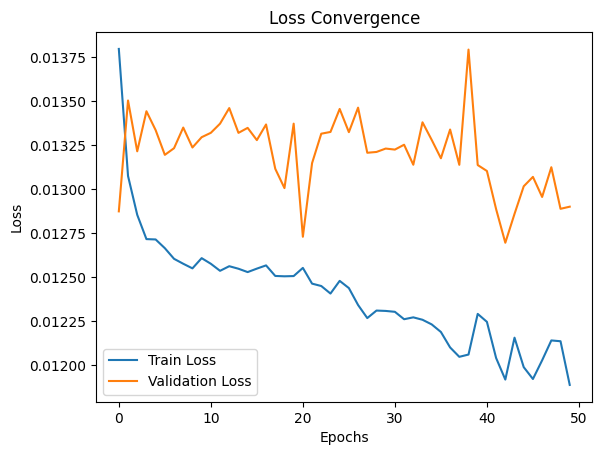

In [27]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Convergence")
plt.show()
